## Business Problem

In 2015, there were 2.1 million cases of breast cancer. This disease is very common and deadly if can't detect at early stage.

The problem goes like:

* The physicians can detect breast cancer with 79% accuracy
* We need a state of art machine learning system that can predict breast cancer correctly with a higher accuracy than benchmark of 79%

If such system can be developed which can detect cancer with a much higher accuracy > 95%, it could complement physicians in detection. 

## Test Machanism

Using 'Fine Needle Aspirant (FNA)', we take sample from breast and then we can get tumor image.

Now there are 2 ways of doing this
1. Make use of recent deep learnign model like CNN model to directly feed images and extract features of tumor and get result
2. First extract features based on tumor images such radius, area etc and then feed it into ML algorithm to classify as either malignant or benign.

## Dataset

* There are 569 rows with a class distribution as: 212 Malignant and 357 Benign. 
* There are 30 odd features that can be used to predict whether tumor is malignant or benign.

We will be using SVM, random forest and XGBoost algorithm to fit over data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('F:/Python Directory/breast_cancer.csv')
print(data.shape)
data.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df = data.drop(['id','Unnamed: 32'], axis = 1)

In [4]:
#class distribution
print('proportion of "Benign": {0:.2f}%'.format((df['diagnosis'].value_counts()[0])/df.shape[0]*100))
print('proportion of "Malignant": {0:.2f}%'.format((df['diagnosis'].value_counts()[1])/df.shape[0]*100))

proportion of "Benign": 62.74%
proportion of "Malignant": 37.26%


In [5]:
df.diagnosis = df.diagnosis.astype('category')

In [6]:
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']
cols = X.columns

#### Feature Engineering

In [7]:
#check for missing values in dataset
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Since there is no missing value in dataset. We don't have to perform missing data imputation.

Absence of any missing values makes sense in such a data which belongs to medical domain and is quite sensitive in nature. If such data would have high number of missing values, imputation of data would not be giving an accurate picture and since we are dealing with a sensitive situation where such imputation can lead to higher error rate due to variation in data leading to error in detection.

#### Normalization and Feature Scaling

Looking at features, it can be observed that there are various ranges of data across variables which might lead to incorrect estimation of a feature importance. A feature seem to high on range. for example 10 - 1000 would seem to be more impotanr than a feature in range 100-200. To covert all features to be on same scale, we need to normalize them all in range between 0-1.

In [8]:
#apply min-max scaler
df_norm = (X - X.mean()) / (X.max() - X.min())
df_norm = pd.concat([df_norm, y], axis = 1)
df_norm.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0.182815,-0.301307,0.213053,0.146813,0.198968,0.531437,0.495081,0.487976,0.306758,0.335139,...,-0.222474,0.385173,0.279792,0.196998,0.399079,0.351207,0.518192,0.335156,0.229268,M
1,0.304923,-0.051392,0.282848,0.284671,-0.104905,-0.078833,-0.004450,0.105621,0.000193,-0.129057,...,-0.060427,0.256680,0.264308,-0.056585,-0.065649,-0.024432,0.245339,-0.029717,0.033282,M
2,0.263274,0.066295,0.262808,0.232497,0.119524,0.170416,0.254453,0.392549,0.129991,-0.059132,...,-0.003924,0.225304,0.203602,0.079452,0.165163,0.142341,0.441216,0.140399,0.023837,M
3,-0.128132,0.036874,-0.099434,-0.114014,0.416536,0.550761,0.357546,0.279726,0.396657,0.729621,...,0.021929,-0.041791,-0.076898,0.511335,0.593799,0.331239,0.491044,0.736693,0.584115,M
4,0.291671,-0.167388,0.298051,0.272369,0.035567,0.087292,0.255859,0.275253,-0.001323,-0.083564,...,-0.240065,0.223810,0.170669,0.033226,-0.047797,0.102086,0.164583,-0.105806,-0.047001,M


#### Visual Data Exploration

To undertsand how features are behaving with respect to each of the 2 classes and correlations and distributions, we can perform visual exploration of data as

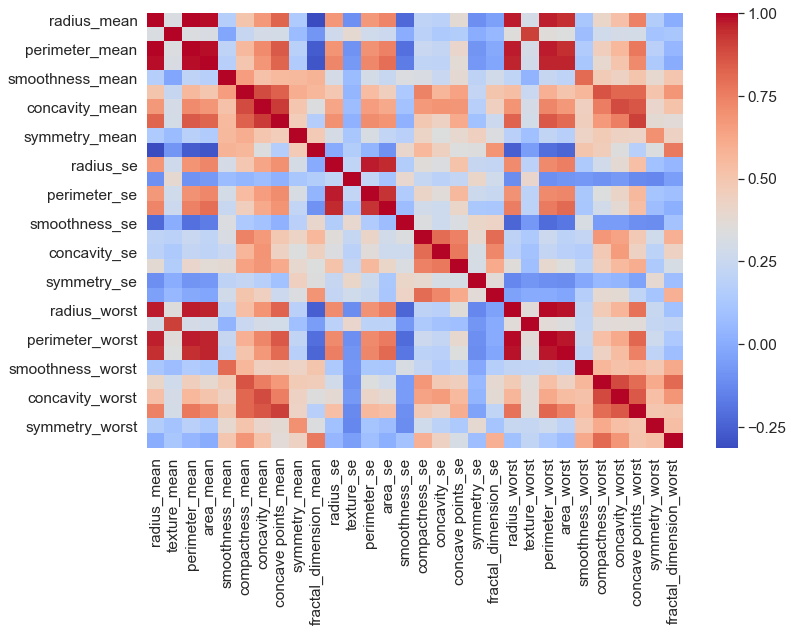

In [9]:
#explore correlation
plt.rcParams['figure.figsize'] = (12,8)
sns.set(font_scale=1.4)
sns.heatmap(df.drop('diagnosis',1).corr(), cmap = 'coolwarm')

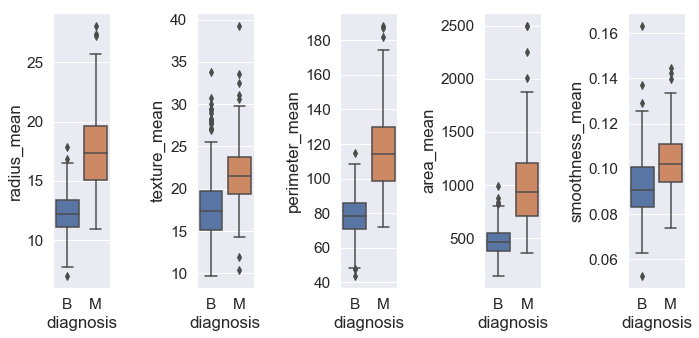

In [10]:
plt.rcParams['figure.figsize'] = (10,5)
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
sns.boxplot('diagnosis', y = 'radius_mean', data = df, ax = ax1)
sns.boxplot('diagnosis', y = 'texture_mean', data = df, ax = ax2)
sns.boxplot('diagnosis', y = 'perimeter_mean', data = df, ax = ax3)
sns.boxplot('diagnosis', y = 'area_mean', data = df, ax = ax4)
sns.boxplot('diagnosis', y = 'smoothness_mean', data = df, ax = ax5)
f.tight_layout()

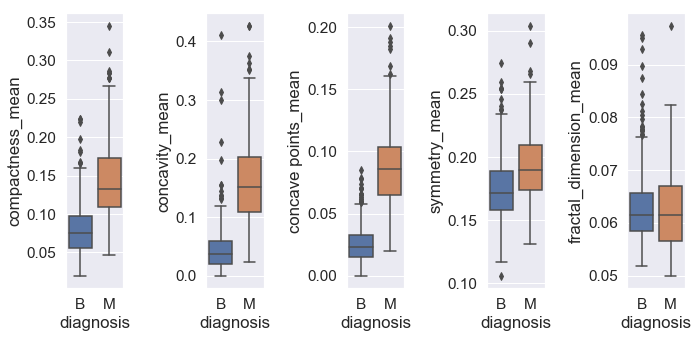

In [11]:
plt.rcParams['figure.figsize'] = (10,5)
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
sns.boxplot('diagnosis', y = 'compactness_mean', data = df, ax = ax1)
sns.boxplot('diagnosis', y = 'concavity_mean', data = df, ax = ax2)
sns.boxplot('diagnosis', y = 'concave points_mean', data = df, ax = ax3)
sns.boxplot('diagnosis', y = 'symmetry_mean', data = df, ax = ax4)
sns.boxplot('diagnosis', y = 'fractal_dimension_mean', data = df, ax = ax5)
f.tight_layout()

We can observe that for every feature plotted above, the median values are higher in case when tumor is malignant. So there is clear discriminating relation between the 2 classes.

Also we counld see some outliers across all features plotted but we are not going to consider removing them or capping them because of 2 reasons:

1. We have very small number of samples in dats
2. Data belongs to medical domain and in such domain outlier do represent sentivity towards detection and are quite important. Outlier treatment in such cases might result in suboptimal solution by suppressing the sensitivity indicated by them.

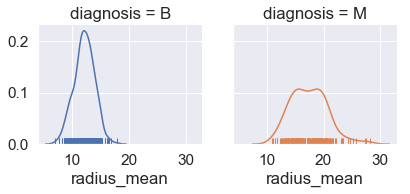

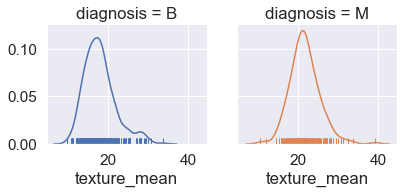

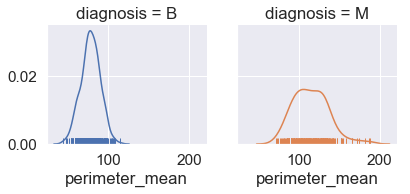

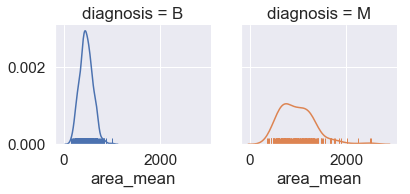

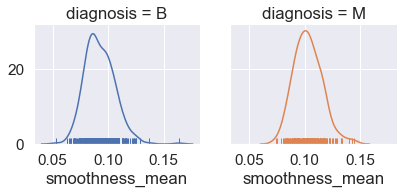

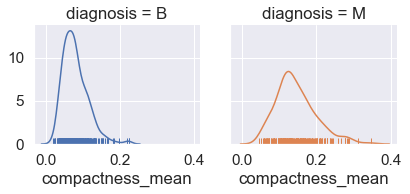

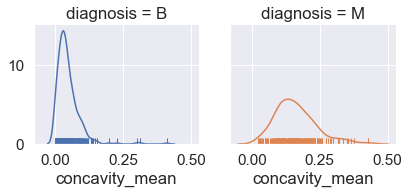

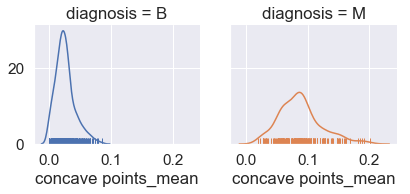

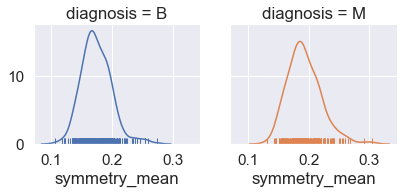

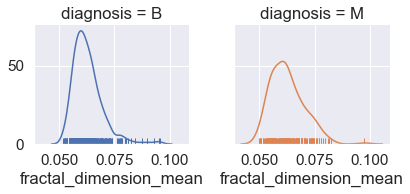

In [12]:
g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'radius_mean', hist = False, rug = True)

g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'texture_mean', hist = False, rug = True)

g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'perimeter_mean', hist = False, rug = True)

g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'area_mean', hist = False, rug = True)

g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'smoothness_mean', hist = False, rug = True)

g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'compactness_mean', hist = False, rug = True)

g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'concavity_mean', hist = False, rug = True)

g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'concave points_mean', hist = False, rug = True)

g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'symmetry_mean', hist = False, rug = True)

g = sns.FacetGrid(df, col = 'diagnosis', hue = 'diagnosis')
g.map(sns.distplot, 'fractal_dimension_mean', hist = False, rug = True)

If we observe distribution of numeric features closely, the distribution looks close to normal especially in case of 'Malignant' class. So we don't need ay kind of transformation to be applied on features like log, exp, box cox etc

Next, we will be plotting smoothness based numeric features in box plot

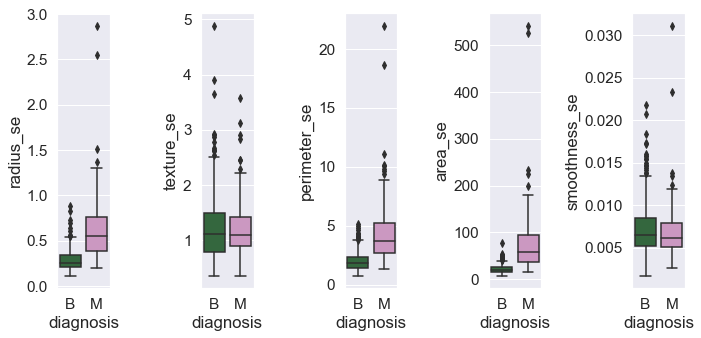

In [13]:
plt.rcParams['figure.figsize'] = (10,5)
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
sns.boxplot('diagnosis', y = 'radius_se', data = df, ax = ax1, palette='cubehelix')
sns.boxplot('diagnosis', y = 'texture_se', data = df, ax = ax2, palette='cubehelix')
sns.boxplot('diagnosis', y = 'perimeter_se', data = df, ax = ax3, palette='cubehelix')
sns.boxplot('diagnosis', y = 'area_se', data = df, ax = ax4, palette='cubehelix')
sns.boxplot('diagnosis', y = 'smoothness_se', data = df, ax = ax5, palette='cubehelix')
f.tight_layout()

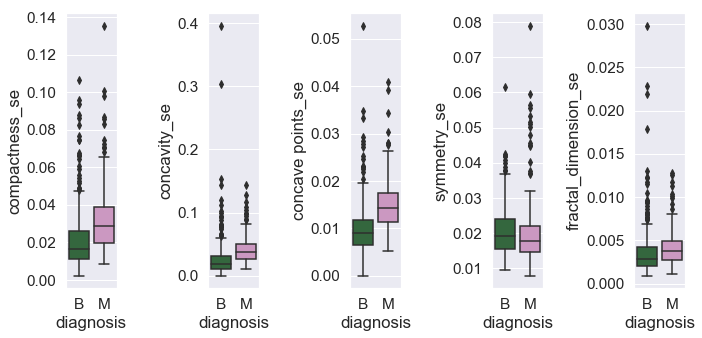

In [14]:
plt.rcParams['figure.figsize'] = (10,5)
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
sns.boxplot('diagnosis', y = 'compactness_se', data = df, ax = ax1, palette='cubehelix')
sns.boxplot('diagnosis', y = 'concavity_se', data = df, ax = ax2, palette='cubehelix')
sns.boxplot('diagnosis', y = 'concave points_se', data = df, ax = ax3, palette='cubehelix')
sns.boxplot('diagnosis', y = 'symmetry_se', data = df, ax = ax4, palette='cubehelix')
sns.boxplot('diagnosis', y = 'fractal_dimension_se', data = df, ax = ax5, palette='cubehelix')
f.tight_layout()

Majority of smoothness based features are also giving a clear discrimination of median between the 2 classes.

Next, we can plot the 'worst' measures

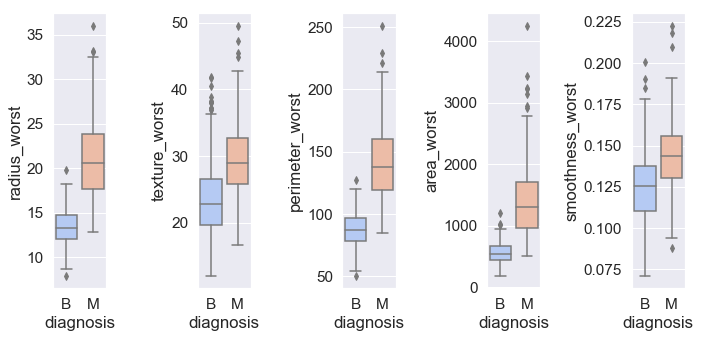

In [15]:
plt.rcParams['figure.figsize'] = (10,5)
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
sns.boxplot('diagnosis', y = 'radius_worst', data = df, ax = ax1, palette='coolwarm')
sns.boxplot('diagnosis', y = 'texture_worst', data = df, ax = ax2, palette='coolwarm')
sns.boxplot('diagnosis', y = 'perimeter_worst', data = df, ax = ax3, palette='coolwarm')
sns.boxplot('diagnosis', y = 'area_worst', data = df, ax = ax4, palette='coolwarm')
sns.boxplot('diagnosis', y = 'smoothness_worst', data = df, ax = ax5, palette='coolwarm')
f.tight_layout()

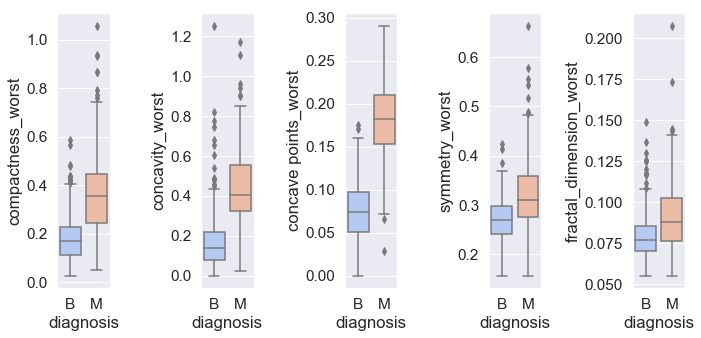

In [16]:
plt.rcParams['figure.figsize'] = (10,5)
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
sns.boxplot('diagnosis', y = 'compactness_worst', data = df, ax = ax1, palette='coolwarm')
sns.boxplot('diagnosis', y = 'concavity_worst', data = df, ax = ax2, palette='coolwarm')
sns.boxplot('diagnosis', y = 'concave points_worst', data = df, ax = ax3, palette='coolwarm')
sns.boxplot('diagnosis', y = 'symmetry_worst', data = df, ax = ax4, palette='coolwarm')
sns.boxplot('diagnosis', y = 'fractal_dimension_worst', data = df, ax = ax5, palette='coolwarm')
f.tight_layout()

'worst' measurement based features also also indicating a high discrimination between the median associated with each of the 2 classes.

We have done different types of EDA here because:

* We wanted to understand correlation among features. If 2 features are highly correlated, they are expected to give the same information to model and won't add any value in prediction. So we can perform feature selection.
* We wanted to understand how each of the numeric is able to discrimate between the values that belongs to each of the 2 classes. Larger the difference in median and distributiion aroubd median between classes, more the discrimination power of feature would be.
* Using distribution plots, we wanted to understand if the distribution of features in both the clases is gaussian. Since ML algorithm works best if the distribution is gaussian. It will be helpful to determine if there is a need for anu sort of transformation.

In [17]:
#encoding target variable 'diagnosis' in normalized data
X_norm = df_norm.drop('diagnosis', axis = 1)
y_norm = df_norm['diagnosis']
y_norm = pd.Series(np.where(y_norm == 'M', 1, 0),name = 'diagnosis')

In [18]:
#or
#le = LabelEncoder()
#y_norm = le.fit_transform(y_norm)

#### Fitting the Model

In [19]:
#functionalize model fitting
def FitModel(X, y, algo_name, algo, gridSearchParams, cv):
    np.random.seed(10)
    #train test split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    #prepare data for SageMaker
    train = pd.concat([y_train, x_train], axis = 1)
    train.to_csv('C:/Users/Manoj/Desktop/train.csv', index = False, header = False)
    y_train.to_csv('C:/Users/Manoj/Desktop/Y-train.csv')
    
    test = pd.concat([y_test, x_test], axis = 1)
    test.to_csv('C:/Users/Manoj/Desktop/test.csv', index = False, header = False)
    y_test.to_csv('C:/Users/Manoj/Desktop/Y-test.csv')
    
    #apply gridsearch for optimal params
    grid = GridSearchCV(estimator = algo,
                       param_grid=gridSearchParams,
                       cv = cv, scoring = 'accuracy', verbose=1, n_jobs=-1)
    
    grid_result = grid.fit(x_train, y_train)
    best_params = grid_result.best_params_
    pred = grid_result.predict(x_test)
    cm = confusion_matrix(y_test, pred)
    #save model
    pickle.dump(grid_result, open(algo_name, 'wb'))
    
    print('Best Params: ', best_params)
    print('Classification Report: ', classification_report(y_test, pred))
    print('Accuracy score: ' + str(accuracy_score(y_test, pred)))
    print('Confusion Matrix: \n', cm)

##### SVM Model

In [20]:
param = {'C': [0.1, 1, 100, 1000],
        'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
FitModel(X_norm, y_norm, 'SVC_norm', SVC(), param, cv = 5)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.5s


Best Params:  {'C': 1, 'gamma': 1}
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.96      0.98        75
           1       0.93      1.00      0.96        39

    accuracy                           0.97       114
   macro avg       0.96      0.98      0.97       114
weighted avg       0.98      0.97      0.97       114

Accuracy score: 0.9736842105263158
Confusion Matrix: 
 [[72  3]
 [ 0 39]]


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    4.8s finished


##### Random Forest Model

In [21]:
param = {'n_estimators': [100, 500, 1000, 2000]}
FitModel(X_norm, y_norm, 'RandomForest_norm', RandomForestClassifier(), param, cv = 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.6s finished


Best Params:  {'n_estimators': 500}
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.97      0.99        75
           1       0.95      1.00      0.97        39

    accuracy                           0.98       114
   macro avg       0.98      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114

Accuracy score: 0.9824561403508771
Confusion Matrix: 
 [[73  2]
 [ 0 39]]


In [22]:
#check for reproducibility of results
np.random.seed(10)

x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size = 0.2)

rf_model = RandomForestClassifier(n_estimators=1000).fit(x_train, y_train)
accuracy = rf_model.score(x_test, y_test)
predict = rf_model.predict(x_test)
cmatrix = confusion_matrix(y_test, predict)
print('Accuracy of Random Forest: %s' % '{0:.2%}'.format(accuracy))

#cross validation
#v = cross_val_score(rf_model, x_train, y_train, cv = 5)
#for i in range(5):
#    print('Cross Validation Score: %s' % '{0:.2%}'.format(v[i,]))

Accuracy of Random Forest: 98.25%


###### Feature Importance

In [23]:
imp = rf_model.feature_importances_
indices = np.argsort(imp)[::-1]

print('Feature ranking:')
for f in range(X.shape[1]):
    print('feature %s {%f}' % (list(X)[f], imp[indices[f]]))

Feature ranking:
feature radius_mean {0.137104}
feature texture_mean {0.128897}
feature perimeter_mean {0.113673}
feature area_mean {0.113143}
feature smoothness_mean {0.085627}
feature compactness_mean {0.060493}
feature concavity_mean {0.050109}
feature concave points_mean {0.046477}
feature symmetry_mean {0.038959}
feature fractal_dimension_mean {0.035794}
feature radius_se {0.032094}
feature texture_se {0.017179}
feature perimeter_se {0.015423}
feature area_se {0.014436}
feature smoothness_se {0.014062}
feature compactness_se {0.012121}
feature concavity_se {0.010424}
feature concave points_se {0.010372}
feature symmetry_se {0.009655}
feature fractal_dimension_se {0.006987}
feature radius_worst {0.006305}
feature texture_worst {0.005685}
feature perimeter_worst {0.005226}
feature area_worst {0.004740}
feature smoothness_worst {0.004600}
feature compactness_worst {0.004443}
feature concavity_worst {0.004438}
feature concave points_worst {0.004210}
feature symmetry_worst {0.004126}
f

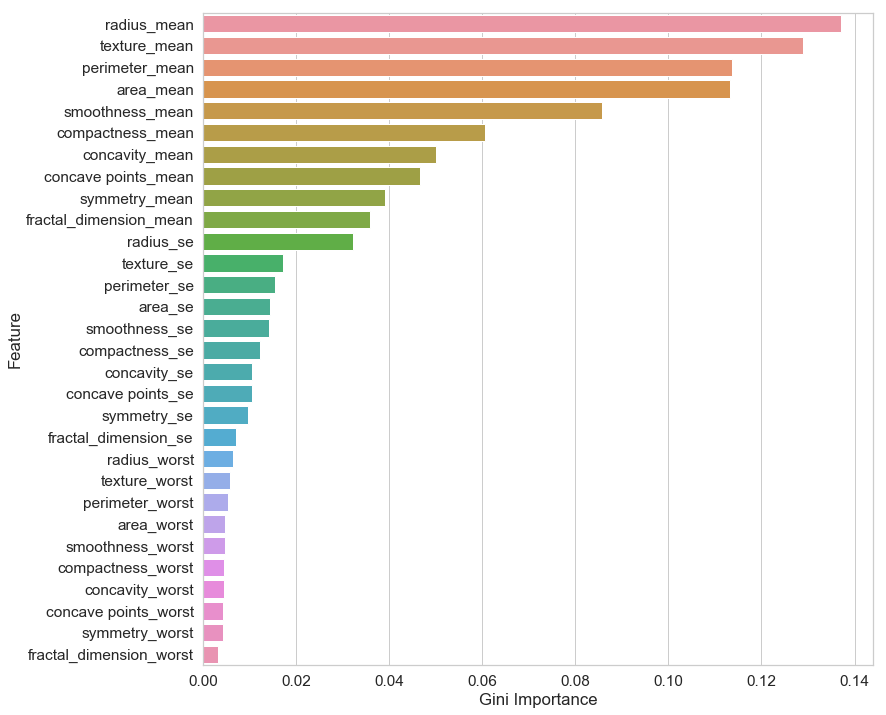

In [24]:
#plotting feature importance
feat_imp = pd.DataFrame({'Feature': list(X),
                        'Gini importance': imp[indices]})
plt.rcParams['figure.figsize'] = (12,12)
sns.set_style('whitegrid')
ax = sns.barplot(x = 'Gini importance', y = 'Feature', data = feat_imp)
ax.set(xlabel = 'Gini Importance')
plt.show()

We can use this feature importance plot for the purpose of feature selection to simplify model fit. But since we already have limited set of features, we can ignore it.

##### XGBoost Model

In [25]:
param = {'n_estimators': [100, 500, 1000, 2000]}
FitModel(X_norm, y_norm, 'XGBoost_norm', XGBClassifier(), param, cv = 5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.9s finished


Best Params:  {'n_estimators': 500}
Classification Report:                precision    recall  f1-score   support

           0       0.99      0.96      0.97        75
           1       0.93      0.97      0.95        39

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Accuracy score: 0.9649122807017544
Confusion Matrix: 
 [[72  3]
 [ 1 38]]


Now if compare all 3 algorithms, the performance of Random Forest is higher with respect to accuracy but we have to note one more thing that incase of XGBoost, both type I and type II errors are made. Which means there 3 FP and 1 FN. Now this has higher cost given the senstivity of domain as wre Ok with FP cases but can't afford a FN. 

##### Balancing Dataset

In this case we will consider oversampling to match proportion of both the classes as we can't afford to reduce number of samples in our majority class as we already have small data.

In [35]:
from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE(random_state = 42).fit_resample(X_norm, y_norm)
X_res = pd.DataFrame(X_res, columns=X_norm.columns)
y_res = pd.Series(y_res, name = y_norm.name)
y_res.value_counts()

1    357
0    357
Name: diagnosis, dtype: int64

In [36]:
#fitting random forest on balanced dataset
param = {'n_estimators': [100, 500, 1000, 2000]}
FitModel(X_res, y_res, 'Random_Forest_res', RandomForestClassifier(), param, cv = 5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.3s finished


Best Params:  {'n_estimators': 100}
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.99      0.99        68
           1       0.99      1.00      0.99        75

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

Accuracy score: 0.993006993006993
Confusion Matrix: 
 [[67  1]
 [ 0 75]]


In [37]:
#fitting SVM on balanced dataset
param = {'C': [0.1, 1, 100, 1000],
        'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
FitModel(X_res, y_res, 'SVC_res', SVC(), param, cv = 5)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Params:  {'C': 1, 'gamma': 1}
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.97      0.99        68
           1       0.97      1.00      0.99        75

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

Accuracy score: 0.986013986013986
Confusion Matrix: 
 [[66  2]
 [ 0 75]]


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.5s finished


In [38]:
#fitting xgboost on balanced dataset
param = {'n_estimators': [100, 500, 1000, 2000]}
FitModel(X_res, y_res, 'XGBoost_res', XGBClassifier(), param, cv = 5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.0s finished


Best Params:  {'n_estimators': 500}
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.99      0.99        68
           1       0.99      1.00      0.99        75

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

Accuracy score: 0.993006993006993
Confusion Matrix: 
 [[67  1]
 [ 0 75]]


##### Feature Selection - using only top k features

In [39]:
feat_imp.index = feat_imp.Feature
feat_to_keep = feat_imp.iloc[:15].index

In [40]:
X_res = pd.DataFrame(X_res)
y_res = pd.DataFrame(y_res)
X_res.columns = X_norm.columns
#fitting xgboost on balanced dataset
param = {'n_estimators': [100, 500, 1000, 2000]}
FitModel(X_res[feat_to_keep], y_res, 'Random Forest', RandomForestClassifier(), param, cv = 5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.7s finished


Best Params:  {'n_estimators': 100}
Classification Report:                precision    recall  f1-score   support

           0       0.99      0.97      0.98        68
           1       0.97      0.99      0.98        75

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

Accuracy score: 0.9790209790209791
Confusion Matrix: 
 [[66  2]
 [ 1 74]]


Since we are dealing with medical domain data, we can't adopt feature selection here as it is resulting into a significant drop in accuracy ~1%. although feature selection helps in reducing computational burden by identifying only the features that are actually important but in a high sensitive domain, where we can't afford to be less accurate. Including all features might be a greate idea!

##### Reloading the saved model

In [43]:
#final model
#fitting xgboost on balanced dataset
param = {'n_estimators': [100, 500, 1000, 2000]}
FitModel(X_res, y_res, 'XGBoost_res', XGBClassifier(), param, cv = 5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished


Best Params:  {'n_estimators': 500}
Classification Report:                precision    recall  f1-score   support

           0       1.00      0.99      0.99        68
           1       0.99      1.00      0.99        75

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

Accuracy score: 0.993006993006993
Confusion Matrix: 
 [[67  1]
 [ 0 75]]


In [44]:
model = pickle.load(open('XGBoost_res', 'rb'))
pred = model.predict(x_test)
model.best_params_

{'n_estimators': 500}

So our final model would be XGBoost trained over resampled dataset!

Let's go ahead and use hyper parameters explored here and implement this model in SageMaker and deploy it to get real time or batch predictions!